
This notebook is based on tutorial for Basic text classification (Sentiment analysis) published on [tensorflow.org](https://www.tensorflow.org/tutorials/keras/text_classification) which I've modified to support multiclass classification.

I've also tried to fine tune the model by trying different combination of layers, however it turned that the tutorial provides reasonable defaults that are hard to beat. In addition, experimenting with LSTM layers proved to be difficult as adding them significantly slowed down the training. Suprisingly enough their inclusion did not improve the accuracy - in fact the exact opposite happend. The highest accuracy achieved while LSTM layer was part of the model was just above 12%, which less than half of otherwise achived accuracy.

The biggest gain for accuracy was made by finding the sweet spot for number of epochs, so that the model doesn't start to overfit. For that I've used the graphs available at the end of this notebook. With that and other improvements described below I've achieved the highest accuracy (on validation dataset) of 25.6%. More specifically - the result precise to 6 significant digits was 25.666666% which I can only assume is a sign that I should not tempt fate further.

Increasing number of embeding dimmensions from 16 to 32 had negligable impact on accuracy.

Changing the maximum number of extracted words (tested for max dictionary size 1 500, 10 000 and 38 000) had a mesurable impact on accuracy - 18%, 23% and 24% respectively. I've decided to stick with dictionary size of 10 000 to limit the number of trainable nodes, as any additional nodes seemed to have very diminishing returns.

Teaching the neural network not on the raw texts, but rather on universal PoS tags was surprisingly (in)accurate - the reached accuracy was 4.62% after 50 iterations with usage of 14 distinct PoS tags. That is more than 10 times more effective, than a random labeling strategy which has accuracy of 0.33%. 

Based on manual inspection of the confidence levels for templates I've noticed that some templates have nearly 100% accuracy in detection and nearly 0% of false positives. In general these seem to be templates that ussualy contain the same long phrase - for example "I do not think it means what you think it means". The high accuracy also occurs when just universal PoS tags are provided as input. This was confirmed (and better visualised) in the Google Machine Learning interface (see relevant section of the report).


In [49]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from typing import Tuple


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# tf.debugging.set_log_device_placement(True)

Num GPUs Available:  0


### Download dataset


In [3]:
url = "https://www.fi.muni.cz/~xborysek/custom_dataset.zip"
# url = "https://www.fi.muni.cz/~xborysek/pos_dataset.zip"


dataset = tf.keras.utils.get_file("custom_dataset2", url,
# dataset = tf.keras.utils.get_file("pos_dataset", url,
                                    extract=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), '.')

In [26]:
# os.listdir(dataset_dir)

In [5]:
train_dir = os.path.join(dataset_dir, 'train')
number_of_labels = len(os.listdir(train_dir))

# os.listdir(train_dir)

### Load the dataset


In [6]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    './train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 60000 files belonging to 299 classes.
Using 48000 files for training.


In [7]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    './train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 60000 files belonging to 299 classes.
Using 12000 files for validation.


In [8]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    './test', 
    batch_size=batch_size)

Found 15000 files belonging to 299 classes.


### Prepare the dataset for training



In [9]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [10]:
max_features = 10000 # orig 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [11]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [12]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [13]:
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

Vocabulary size: 10000


In [14]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Configure the dataset for performance


In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model


In [16]:
embedding_dim = 16

In [17]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
#   layers.Dense(8),
#   layers.Dense(8),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(number_of_labels)
  # layers.Dense(number_of_labels, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 299)               5083      
                                                                 
Total params: 165,099
Trainable params: 165,099
Non-trainable params: 0
__________________________________________________

### Loss function and optimizer


In [18]:
# model.compile(loss='categorical_crossentropy',
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
#              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))
              metrics=['accuracy'])

### Train the model


In [19]:
epochs = 150 # orig 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/150
1500/1500 [==============================] - 19s 13ms/step - loss: 5.7005 - accuracy: 0.0064 - val_loss: 5.6999 - val_accuracy: 0.0064
Epoch 2/150
1500/1500 [==============================] - 4s 3ms/step - loss: 5.6945 - accuracy: 0.0068 - val_loss: 5.6923 - val_accuracy: 0.0064
Epoch 3/150
1500/1500 [==============================] - 4s 3ms/step - loss: 5.6781 - accuracy: 0.0076 - val_loss: 5.6705 - val_accuracy: 0.0129
Epoch 4/150
1500/1500 [==============================] - 4s 3ms/step - loss: 5.6445 - accuracy: 0.0156 - val_loss: 5.6292 - val_accuracy: 0.0259
Epoch 5/150
1500/1500 [==============================] - 4s 3ms/step - loss: 5.5905 - accuracy: 0.0243 - val_loss: 5.5688 - val_accuracy: 0.0299
Epoch 6/150
1500/1500 [==============================] - 4s 3ms/step - loss: 5.5204 - accuracy: 0.0326 - val_loss: 5.4959 - val_accuracy: 0.0397
Epoch 7/150
1500/1500 [==============================] - 4s 3ms/step - loss: 5.4421 - accuracy: 0.0463 - val_loss: 5.4195 - val_

1500/1500 [==============================] - 4s 3ms/step - loss: 3.6595 - accuracy: 0.2570 - val_loss: 3.8644 - val_accuracy: 0.2498
Epoch 114/150
1500/1500 [==============================] - 4s 3ms/step - loss: 3.6553 - accuracy: 0.2570 - val_loss: 3.8607 - val_accuracy: 0.2502
Epoch 115/150
1500/1500 [==============================] - 4s 3ms/step - loss: 3.6516 - accuracy: 0.2590 - val_loss: 3.8587 - val_accuracy: 0.2514
Epoch 116/150
1500/1500 [==============================] - 4s 3ms/step - loss: 3.6469 - accuracy: 0.2595 - val_loss: 3.8585 - val_accuracy: 0.2510
Epoch 117/150
1500/1500 [==============================] - 4s 3ms/step - loss: 3.6456 - accuracy: 0.2581 - val_loss: 3.8581 - val_accuracy: 0.2500
Epoch 118/150
1500/1500 [==============================] - 4s 3ms/step - loss: 3.6361 - accuracy: 0.2605 - val_loss: 3.8530 - val_accuracy: 0.2526
Epoch 119/150
1500/1500 [==============================] - 4s 3ms/step - loss: 3.6335 - accuracy: 0.2599 - val_loss: 3.8520 - val_ac

### Evaluate the model

In [20]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

469/469 [==============================] - 10s 20ms/step - loss: 3.7760 - accuracy: 0.2567
Loss:  3.7760207653045654
Accuracy:  0.2566666603088379


In [21]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

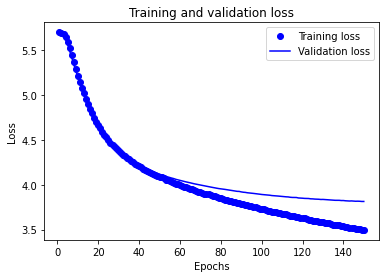

In [27]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

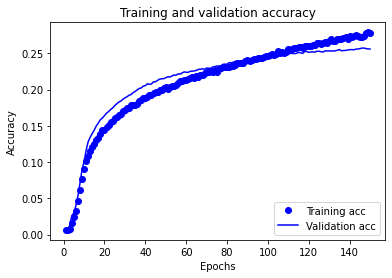

In [23]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

## Export the model


In [28]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  # layers.Activation('sigmoid')
  layers.Activation('softmax')
])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

469/469 [==============================] - 3s 6ms/step - loss: 3.7760 - accuracy: 0.2567
0.2566666603088379


### Inference on new data


In [55]:
def make_prediction(model, text: str) -> Tuple[str, float]:
    prediction = model.predict([text])
    
    max_confidence = max(prediction.tolist()[0])
    index = prediction.tolist()[0].index(max_confidence)
    
    return raw_train_ds.class_names[index], max_confidence

In [61]:
make_prediction(export_model, "Out of arrows <sep> use the one in knee")

('skyrim_stan', 0.04372226446866989)

In [71]:
make_prediction(export_model, "If 666 is evil <sep> is 25.80697580 the root of all evil?")

('Conspiracy_Keanu', 0.11020059883594513)

In [69]:
# Even though this meme breaks the format "One does not simply <sep> <SOMETHING>"
# it's still being detected correctly with 94% confindence!
make_prediction(export_model, "talk like yoda <sep> One simply does not") 

('One_Does_Not_Simply', 0.9408479928970337)